# Damped genetic oscillator

The simplest GRN exhibiting oscillatory behaviors can be modeled through two variables $x_1$ and $x_2$ with opposite mutual effects: $x_1$ catalyzes the production of $x_2$, that in turn inhibits the production of $x_1$. We suppose that the system can be externally controlled by a chemical inducer that targets only one of the genes. The model is defined as
$$
\left\{ \begin{array}{l}
\dot{x}_1 = -\gamma_1 x_1 + u(t) k_1 s^{-}(x_2,\theta_2) , \\
\dot{x}_2 = -\gamma_2 x_2 + k_2  s^{+}(x_1,\theta_1).
\end{array}\right.
$$
where a detail of each term can be found in [Introduction](index.md#context).

For any initial condition, the openloop system (i.e, $u \equiv 1$) converges to the equilibrium point $(\theta_1, \theta_2)$ when $t \rightarrow \infty$, producing a damped oscillatory behavior[^1]:

![Alt Text](openloop.png)

The control objective is to induce a sustained oscillation. Thus, we can state the problem of producing a single cycle, which can be written through the initial and terminal constraints:
$$
    x(0) = x(t_f) = (x_1^c, \theta_2 )
$$
for free final time $t_f > 0$ and for $x_1^c > \theta_1$.

## Problem definition

In [1]:
using Plots
using Plots.PlotMeasures
using OptimalControl
using NLPModelsIpopt
nothing # hide

We define the regularization functions, where the method is decided through the argument `regMethod`.

In [2]:
# Regularization of the PWL dynamics
function s⁺(x, θ, regMethod)
    if regMethod == 1 # Hill
        out = x^k/(x^k + θ^k)
    elseif regMethod == 2 # Exponential
        out = 1 - 1/(1 + exp(k*(x-θ)))
    end
    return out
end

# Regularization of |u(t) - 1|
function abs_m1(u, regMethod)
    if regMethod == 1 # Hill
        out = (u^k - 1)/(u^k + 1)
    elseif regMethod == 2 # Exponential
        out = 1 - 2/(1 + exp(k*(u-1)))
    end
    return out*(u - 1)
end
nothing # hide

Definition of the OCP:

In [3]:
# Constant definition
k₁ = 2;
k₂ = 3     # Production rates
γ₁ = 0.2;
γ₂ = 0.3   # Degradation rates
θ₁ = 4;
θ₂ = 3     # Transcriptional thresholds
uₘᵢₙ = 0.6;
uₘₐₓ = 1.4   # Control bounds
x₁ᶜ = 4.7                 # Cycle point (initial and final)
λ = 0.5                 # Trade-off fuel/time

# Initial guest for the NLP
tf = 1
u(t) = 1
sol = (control=u, variable=tf)

# Optimal control problem definition
ocp = @def begin
    tf ∈ R, variable
    t ∈ [0, tf], time
    x = (x₁, x₂) ∈ R², state
    u ∈ R, control

    x₁(0) == x₁ᶜ
    x₂(0) == θ₂
    x₁(tf) == x₁ᶜ
    x₂(tf) == θ₂

    uₘᵢₙ ≤ u(t) ≤ uₘₐₓ
    tf ≥ 1 # Force the state out of the confort zone

    ẋ(t) == [
        - γ₁*x₁(t) + k₁*u(t)*(1 - s⁺(x₂(t), θ₂, regMethod)),
        - γ₂*x₂(t) + k₂*s⁺(x₁(t), θ₁, regMethod),
    ]

    ∫(λ*abs_m1(u(t), regMethod) + 1-λ) → min
end
nothing # hide

## Resolution through Hill regularization

In order to ensure convergence of the solver, we solve the OCP by iteratively increasing the parameter $k$ while using the $i-1$-th solution as the initialization of the $i$-th iteration.

In [4]:
regMethod = 1       # Hill regularization
ki = 10             # Value of k for the first iteration
N = 400
maxki = 30          # Value of k for the last iteration
while ki < maxki
    global ki += 10  # Iteration step
    local print_level = (ki == maxki) # Only print the output on the last iteration
    global k = ki
    global sol = solve(ocp; grid_size=N, init=sol, print_level=4*print_level)
end
nothing # hide

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

Total number of variables............................:     1605
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      401
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1205
Total number of inequality constraints...............:        0
        inequali

Plotting of the results:

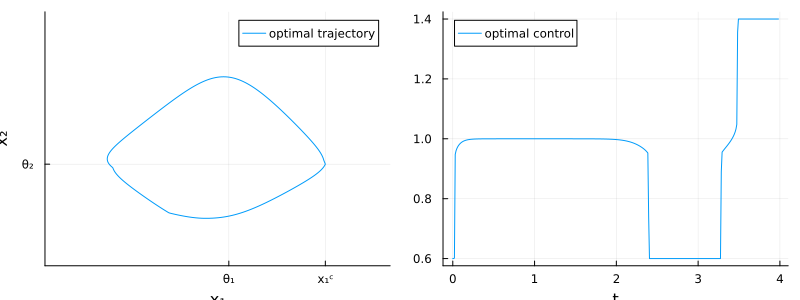

In [5]:
plt1 = plot()
plt2 = plot()

tf = variable(sol)
tspan = range(0, tf, N)   # time interval
x₁(t) = state(sol)(t)[1]
x₂(t) = state(sol)(t)[2]
u(t) = control(sol)(t)

xticks = ([0, θ₁, x₁ᶜ], ["0", "θ₁", "x₁ᶜ"])
yticks = ([0, θ₂], ["0", "θ₂"])

plot!(
    plt1,
    x₁.(tspan),
    x₂.(tspan);
    label="optimal trajectory",
    xlabel="x₁",
    ylabel="x₂",
    xlimits=(θ₁/1.5, 1.1*x₁ᶜ),
    ylimits=(θ₂/2, 1.75*θ₂),
)
xticks!(xticks)
yticks!(yticks)
plot!(plt2, tspan, u; label="optimal control", xlabel="t")
plot(plt1, plt2; layout=(1, 2), size=(800, 300))

## Resolution through exponential regularization

The same procedure for iteratively increasing $k$ is used.

In [6]:
regMethod = 2       # Exponential regularization
ki = 100             # Value of k for the first iteration
N = 400
maxki = 400          # Value of k for the last iteration
while ki < maxki
    global ki += 100  # Iteration step
    local print_level = (ki == maxki) # Only print the output on the last iteration
    global k = ki
    global sol = solve(ocp; grid_size=N, init=sol, print_level=4*print_level)
end
nothing # hide

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

Total number of variables............................:     1605
                     variables with 

Plotting of the results:

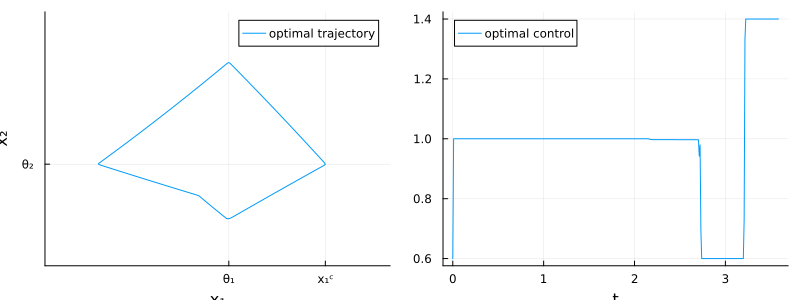

In [7]:
plt1 = plot()
plt2 = plot()

tf = variable(sol)
tspan = range(0, tf, N)   # time interval
x₁(t) = state(sol)(t)[1]
x₂(t) = state(sol)(t)[2]
u(t) = control(sol)(t)

xticks = ([0, θ₁, x₁ᶜ], ["0", "θ₁", "x₁ᶜ"])
yticks = ([0, θ₂], ["0", "θ₂"])

plot!(
    plt1,
    x₁.(tspan),
    x₂.(tspan);
    label="optimal trajectory",
    xlabel="x₁",
    ylabel="x₂",
    xlimits=(θ₁/1.5, 1.1*x₁ᶜ),
    ylimits=(θ₂/2, 1.75*θ₂),
)
xticks!(xticks)
yticks!(yticks)
plot!(plt2, tspan, u; label="optimal control", xlabel="t")
plot(plt1, plt2; layout=(1, 2), size=(800, 300))

[^1]: E. Farcot, J.-L. Gouzé, Periodic solutions of piecewise affine gene network models with non uniform decay rates: the case of a negative feedback loop, Acta biotheoretica 57 (4) (2009) 429–455. -->

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*